# Analysis Work
I will be doing all of my work for this zillow project in this notebook.

<hr style="border:2px solid blue"> </hr>

# Acquire

In [1]:
# Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from env import host, user, password
import os

# My Zillow Functions
import wrangle

# Block Warning Boxes
import warnings
warnings.filterwarnings("ignore")


For now I am only going to acquire `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips` from the zillow database for all 'Single Family Residential' properties. This should allow me to get my MVP.


In [2]:
def get_connection(database_name):
    '''
    This function takes in a string representing a database name for the Codeup mySQL server 
    and returns a string that can be used to open a connection to the server.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database_name}'


In [3]:
def get_zillow_data():
    '''
    This function reads the Zillow database from the Codeup mySQL server and  returns a dataframe.
    If a local file does not exist, this function writes data to a csv file as a backup. The local file 
    ensures that data can be accessed, in the event that you cannot talk to the mySQL database. 
    '''
    # The filename will have 2017 at the end to represent that the only data being looked at is 
    # properties from the year 2017
    if os.path.isfile('zillow2017.csv'):
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow2017.csv', index_col=0)
        
    else:
        
        # Read fresh data from database into a DataFrame
        # property land use type id is limited to 'Single Family Residential' properties.
        df =  pd.read_sql(""" SELECT bedroomcnt, 
                                     bathroomcnt, 
                                     calculatedfinishedsquarefeet, 
                                     yearbuilt, 
                                     regionidzip, 
                                     fips,
                                     taxvaluedollarcnt
                              FROM properties_2017
                              JOIN predictions_2017 USING (parcelid)
                              WHERE propertylandusetypeid = 261;""", 
                            get_connection('zillow')
                        )
        # Cache data into a csv backup
        df.to_csv('zillow2017.csv')
    
    # Renaming column names to one's I like better
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'squarefeet',
                          'taxvaluedollarcnt':'tax_value', 
                          'yearbuilt':'year_built'})   
    return df

I noticed there is an 'Inferred Family Housing' properties type. Upon inspection, I decided not to add this to my dataframe because it only contained a single row with nulss.

In [4]:
zillow = get_zillow_data()
zillow.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0


In [5]:
zillow.shape

(52442, 7)

In [6]:
zillow.describe()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
count,52442.000000,52442.000000,52360.000000,52326.000000,52416.000000,52442.000000,5.244100e+04
mean,3.300675,2.299397,1922.874083,1963.393820,96635.843559,6049.131917,5.296830e+05
std,0.949086,1.022764,1004.363491,23.133355,4605.063649,21.028933,7.518883e+05
min,0.000000,0.000000,128.000000,1878.000000,95982.000000,6037.000000,1.000000e+03
25%,3.000000,2.000000,1268.000000,1950.000000,96206.000000,6037.000000,1.937500e+05
50%,3.000000,2.000000,1659.000000,1961.000000,96412.000000,6037.000000,3.736120e+05
75%,4.000000,3.000000,2306.000000,1979.000000,96995.000000,6059.000000,6.193010e+05
max,14.000000,18.000000,21929.000000,2016.000000,399675.000000,6111.000000,4.906124e+07


Looks like the average bedroom count is 3 and average bathroom count is 2. I'll keep this in mind when I get to explore and modeling.

<hr style="border:2px solid blue"> </hr>

# Prepare

In [7]:
# This dataset is a bit larger, so I will need to set verbose and null_counts to true
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52442 non-null  float64
 1   bathrooms    52442 non-null  float64
 2   squarefeet   52360 non-null  float64
 3   year_built   52326 non-null  float64
 4   regionidzip  52416 non-null  float64
 5   fips         52442 non-null  float64
 6   tax_value    52441 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [8]:
# I can see I have some null values, let's see how many in each column:
zillow.isnull().sum()

bedrooms         0
bathrooms        0
squarefeet      82
year_built     116
regionidzip     26
fips             0
tax_value        1
dtype: int64

In [9]:
# What percentage of my data is this?
zillow.isnull().sum().sum() / zillow.shape[0]

0.004290454216086343

- If I were to remove all rows with nulls, this would remove less than 1% of my data. 
- I think it would be safe to drop all nulls and not have it affect my future explore and modeling


In [10]:
# Dropping all rows with null values
before = zillow.shape[0]
zillow = zillow.dropna()
print ((before - zillow.shape[0]), 'rows dropped')

141 rows dropped


In [11]:
# Making sure my non-null counts look good
zillow.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52301 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52301 non-null  float64
 1   bathrooms    52301 non-null  float64
 2   squarefeet   52301 non-null  float64
 3   year_built   52301 non-null  float64
 4   regionidzip  52301 non-null  float64
 5   fips         52301 non-null  float64
 6   tax_value    52301 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


#### Notes:
Now to take a look at Dtypes for each row.

- I believe Bedrooms are supposed to be whole numbers, so I'll change this row to integers.
- Bathrooms are known to have wierd numbers like 2.5 Bath, so float makes sense here.  
- squarefeet can stay a float 
- I should probably change yearbuilt to an integer
- regionidzip is zipcodes, which we know are integers.  
  
- Also, I googled fips because I didn't know what it was:  
    - Federal Information Processing System (FIPS) Codes for States and Counties. 
    - FIPS codes are numbers which uniquely identify geographic areas.  
  
- It looks like fips are whole numbers, so I'll make that an integer too!   
- tax_value is money, so a float works just fine here


In [12]:
# Just to be sure, I'm going to check and see if any of the bedroom counts utilize this decimal
zillow.bedrooms[(zillow.bedrooms % 1) != 0]

Series([], Name: bedrooms, dtype: float64)

Nope! Looks like I'm okay to change bedrooms into integers.

In [13]:
zillow["regionidzip"] = zillow.regionidzip.astype(int)
zillow["bedrooms"] = zillow.bedrooms.astype(int)
zillow["year_built"] = zillow.year_built.astype(int)
zillow["fips"] = zillow.fips.astype(int)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52301 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52301 non-null  int64  
 1   bathrooms    52301 non-null  float64
 2   squarefeet   52301 non-null  float64
 3   year_built   52301 non-null  int64  
 4   regionidzip  52301 non-null  int64  
 5   fips         52301 non-null  int64  
 6   tax_value    52301 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.2 MB


In [14]:
# I noticed some rows with zero bedrooms. Are there some nulls in my data disguised as zeros?
zillow[(zillow.bathrooms == 0) | (zillow.bedrooms == 0) | (zillow.squarefeet == 0)]

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value
590,0,5.0,5782.0,2006,96120,6037,4626995.0
2694,0,0.0,1208.0,1990,95984,6037,185161.0
2899,0,0.0,280.0,1953,96267,6037,963472.0
3261,0,1.0,288.0,1922,96023,6037,67521.0
4675,0,1.0,480.0,1948,96217,6037,227272.0
...,...,...,...,...,...,...,...
51299,0,0.0,984.0,1927,95982,6037,183027.0
51811,0,1.0,1150.0,1930,95995,6037,158000.0
52163,0,0.0,2307.0,1948,96100,6037,499000.0
52175,0,1.0,440.0,1947,96027,6037,1374602.0


#### That's another 73 rows of data with null values. 
Could these zeros represent a vacant lot that hasn't been built yet? It seems that there is a separate category for this in the database called "Vacant Land - General", so probably not.

- ( 73 + 141 )/52442 = 0.408%
- that's still less than 1% of our original data.
- If I drop these 73 rows with zeros plus the 141 rows with nulls, I will still have lost less than 1% of my data which means it shouldn't effect my exploration and modeling. 

In [15]:
before = zillow.shape[0]
zillow = zillow[(zillow.bathrooms != 0) & (zillow.bedrooms != 0) & (zillow.squarefeet != 0)]
print((before - zillow.shape[0]),"rows dropped" )

73 rows dropped


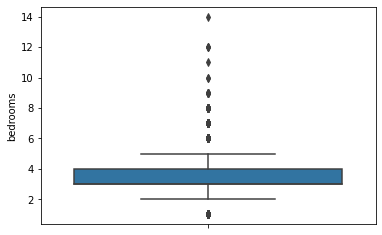

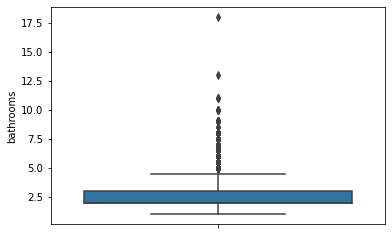

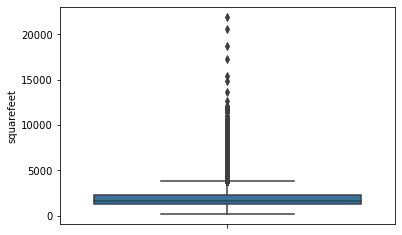

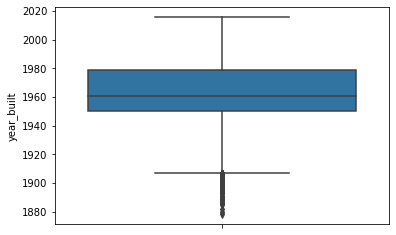

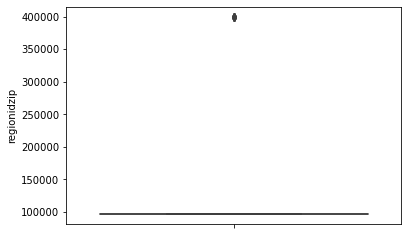

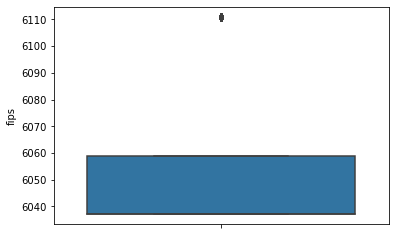

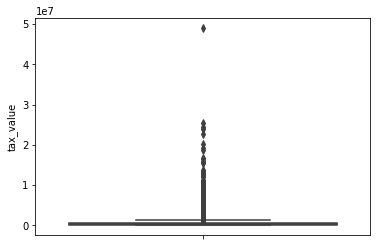

In [16]:
# Next is to look for outliers. I'll start this task by first taking a visual look at my columns. 

columns = zillow.columns

# Create boxplots for each column
for x in columns:
    sns.boxplot(data= zillow, y = x)
    plt.title('')
    plt.show()

- bedrooms: I don't really want a Kim Kardashian house with 14 bedrooms for my model. I believe these houses might be outliers for my Single Family Residential properties. 
- bathrooms: The same can be said for bathrooms.
- squarefeet: I believe taking care of squarefeet might resolve bedrooms and bathrooms
- yearbuilt: I don't see anything worrisome here.
- regionidzip: I'll have to investigate these outliers before removing
- fips: I'll have to investigate these outliers before removing
- tax_value: I'll definitely scale my target to ensure the best model down the line

In [17]:
def remove_outliers(df, k, col_list):
    ''' 
    This dataframe takes in a dataframe, a define k, and the list of columns to be checked for outliers.
    The outliers are removed based on statistical upper and lower bounds, and a dataframe of 
    remaining rows is returned.
    '''

    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # Return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [24]:
before = zillow.shape[0]
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 
                                      'bathrooms', 
                                      'squarefeet', 
                                      #'year_built', 
                                      #'regionidzip',
                                      #'fips', 
                                      'tax_value'])

print((before - zillow.shape[0]), 'rows dropped')

6639 rows dropped


- (6639 + 141 + 73)/52442 = 13.08%
- After removing nulls, zeros, and outliers I have lost approximately 13% of my data. This should still be a low enough number not to affect my exploration and models 

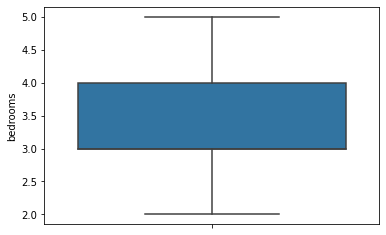

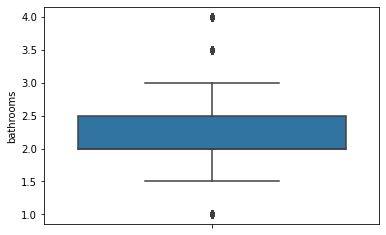

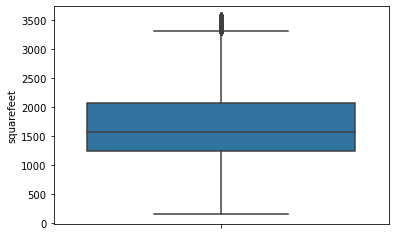

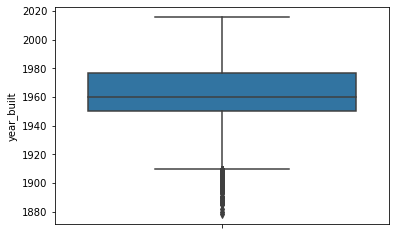

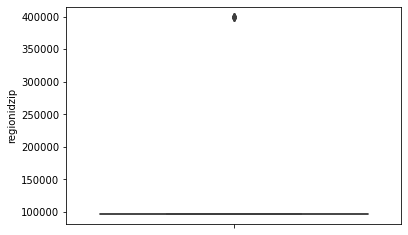

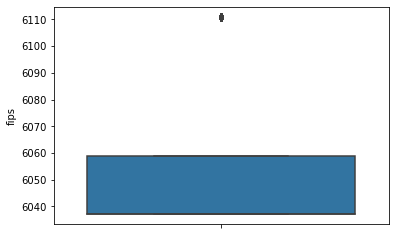

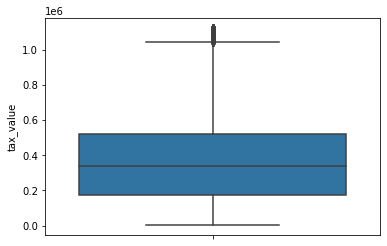

In [25]:
# Let's take another look at our columns after removing the more extreme outliers
for x in zillow.columns:
    sns.boxplot(data= larry, y = x)
    plt.title('')
    plt.show()

Now that my data is starting to look a lot cleaner, I'm gonna scale it and then I'll be ready to explore!

In [ ]:
# First I have to split the data. The scaling has to be fitted, which means I need my Train dataset
# Note: When scaling, fit on train and then apply to validate and test. 
train , validate, test = wrangle.wrangle_zillow()

In [23]:
def Min_Max_Scaler(train, validate, test):
    """
    Takes in the pre-split data and uses train to fit the scaler. The scaler is then applied to all dataframes and 
    the dataframes are returned in thier scaled form.
    """
    # 1. Create the object
    scaler = sklearn.preprocessing.MinMaxScaler()

    # 2. Fit the object (learn the min and max value)
    scaler.fit(train[['taxamount', 'tax_value']])

    # 3. Use the object (use the min, max to do the transformation)
    train[['taxamount', 'tax_value']] = scaler.transform(train[['taxamount', 'tax_value']])
    test[['taxamount', 'tax_value']] = scaler.transform(test[['taxamount', 'tax_value']])
    validate[['taxamount', 'tax_value']] = scaler.transform(validate[['taxamount', 'tax_value']])
    
    return train, validate, test

0.1338936968675806

In [ ]:
remake wrangle, then scale data

Plan -> Acquire -> Prepare -> Explore -> Model & Evaluate -> Deliver
